In [1]:
import torch
from typing import List, Dict, Tuple
from random import choices

# Support for ARM64 Mac Devices
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [2]:
import zipfile as zf
import os

# Extracts Demo Files from ZIP Archives
def extract_demo_files(demo_dir: str = '/Users/mattkingsbury/cs_msc/comp_demos', 
                       expr_dir: str = '/Users/mattkingsbury/cs_msc/decomp_demos') -> None:
    for filename in os.listdir(demo_dir):
        if filename.endswith('.zip'):
            zip_path = os.path.join(demo_dir, filename)
            with zf.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(expr_dir)

extract_demo_files()
demoNames = [fileName for fileName in os.listdir('/Users/mattkingsbury/cs_msc/decomp_demos') if fileName.endswith('dem')]

KeyboardInterrupt: 

In [ ]:
from awpy import DemoParser
from awpy.analytics.stats import player_stats

# Parses a Demo File into a .json File
def parser(file: str) -> Tuple[str, any]:
    fpath = '/Users/mattkingsbury/cs_msc/decomp_demos/'
    id = ''.join(choices(file, k = 12))
    demo_parser = DemoParser(
        demofile = fpath + file, 
        demo_id = id, 
        parse_rate = 128, 
        trade_time = 5, 
        buy_style = "hltv"
    )

    demo = demo_parser.parse()
    return (id, demo)


In [ ]:
from helpers import arr_to_dict, euclidean_distance, add_trajectory, traj_Seconds

# Retrieves Statistics and Player Trajectories for a Match
def get_team_stats_and_trajectories(demo_and_id: Tuple[str, any]) -> Dict[str, Tuple[List[float], List[float]]]:
    (id, demo) = demo_and_id
    teams: List[str] = [None, None]
    team1_stats: List[float] = [0.] * 14
    team2_stats: List[float] = [0.] * 14
    num_rounds: int = 0

    # Player Stats
    stats_per_player: Dict = player_stats(demo["gameRounds"])
    for stats in stats_per_player.values():
        num_rounds = max(num_rounds, stats['totalRounds'])
        curr_player_team = stats['teamName']
        clutch_successes: List[float] = sum([
            stats['success1v1'], 
            stats['success1v2'], 
            stats['success1v3'], 
            stats['success1v4'], 
            stats['success1v5']])
        clutch_attempts: List[float] = sum([
            stats['attempts1v1'], 
            stats['attempts1v2'], 
            stats['attempts1v3'], 
            stats['attempts1v4'], 
            stats['attempts1v5']])
        curr_player_stats: List[float] = [ 
            stats['kills'], # Kills
            sum([stats['kills2'], stats['kills3'], stats['kills4'], stats['kills5']]), # Multi-Kills
            stats['firstKills'], # Entry-Kills
            stats['totalDamageGiven'], # Damage Dealt
            stats['totalDamageTaken'], # Damage Taken
            stats['hsPercent'], # Player Headshot Percentage
            stats['plants'], # Times Player Planted Bomb
            stats['defuses'], # Times Player Defused Bomb
            stats['flashAssists'], # Count Enemies Flashed + Killed By Team While Blind
            stats['smokesThrown'], # Count Smokes Thrown
            stats['utilityDamage'], # Total Damage Enemies Received From Player Utility (Grenades, Molotovs)
            stats['tradeKills'], # Times Player Killed Enemy Immediately After Enemy Killed Teammate
            clutch_successes / clutch_attempts if clutch_attempts > 0 else None, # Clutch Conversion Probability
            stats['teamKills'] + stats['suicides'] # Sum (Player Killed Teammate, Player Killed Self) 
        ]

        # Separate Stats by Team
        if teams[0] == None or teams[0] == curr_player_team: 
            teams[0] = curr_player_team
            team1_stats = [None if x is None or y is None else x + y for x, y in zip(curr_player_stats, team1_stats)]
        elif teams[1] == None or teams[1] == curr_player_team:
            teams[1] = curr_player_team
            team2_stats = [None if x is None or y is None else x + y for x, y in zip(curr_player_stats, team2_stats)]

    # Sum Team Stats for Bomb and Kill Events
    sum_team1_time_to_plant, team1_num_plants, sum_team1_kills_dist, team1_num_kills = 0, 0, 0, 0
    sum_team2_time_to_plant, team2_num_plants, sum_team2_kills_dist, team2_num_kills = 0, 0, 0, 0
    team1_kills_type: Dict[str, int] = { 'pistols': 0, 'rifle': 0, 'smg': 0, 'heavy': 0 }
    team2_kills_type: Dict[str, int] = { 'pistols': 0, 'rifle': 0, 'smg': 0, 'heavy': 0 }
    trajectories:  Dict[str, Dict[int, List[Tuple[float, float]]]] = {}

    # Number of Seconds to Analyse Trajectories
    seconds: int = traj_Seconds(12)()
    for round in demo['gameRounds']:
        for bombEvent in round['bombEvents']:
            if bombEvent['bombAction'] == 'plant':
                if bombEvent['playerTeam'] == teams[0]:
                    sum_team1_time_to_plant += bombEvent['seconds']
                    team1_num_plants += 1
                else:
                    sum_team2_time_to_plant += bombEvent['seconds']
                    team2_num_plants += 1
                break
        for killEvent in round['kills']:
            if killEvent['attackerTeam'] == teams[0]:
                if killEvent['weaponClass'] in team1_kills_type:
                    team1_kills_type[killEvent['weaponClass']] += 1
                sum_team1_kills_dist += euclidean_distance(
                    (killEvent['attackerX'], killEvent['attackerY'], killEvent['attackerZ']),
                    (killEvent['victimX'], killEvent['victimY'], killEvent['victimZ'])
                )
                team1_num_kills += 1
            else:
                if killEvent['weaponClass'] in team2_kills_type:
                    team2_kills_type[killEvent['weaponClass']] += 1
                sum_team2_kills_dist += euclidean_distance(
                    (killEvent['attackerX'], killEvent['attackerY'], killEvent['attackerZ']),
                    (killEvent['victimX'], killEvent['victimY'], killEvent['victimZ'])
                )
                team2_num_kills += 1
        for frames in round['frames']:
            if frames['seconds'] >= seconds:
                break
            for team in ['t', 'ct']:
                for player in frames[team]['players']:
                    position: Tuple[float, float] = (player['x'], player['y'])
                    key: str = player['name'] + ':' + str(player['steamID'])
                    add_trajectory(
                        key, 
                        round['roundNum'], 
                        position, 
                        trajectories
                    )

    # Avg Time For Team To Plant Per Round
    avg_team1_plant_time: float = None if team1_num_plants == 0 else sum_team1_time_to_plant / team1_num_plants
    avg_team2_plant_time: float = None if team2_num_plants == 0 else sum_team2_time_to_plant / team2_num_plants

    # Avg Distance Per Kill For Each Team
    avg_team1_kills_dist: float = None if team1_num_kills == 0 else sum_team1_kills_dist / team1_num_kills
    avg_team2_kills_dist: float = None if team2_num_kills == 0 else sum_team2_kills_dist / team2_num_kills

    # Calculate Avg Team Statistics
    team1_stats_pr: List[float] = [
        *(None if stat is None else stat / num_rounds for stat in team1_stats),
        *(team1_kills_type[kill_type] for kill_type in team1_kills_type),
        avg_team1_plant_time,
        avg_team1_kills_dist,
    ]

    team2_stats_pr: List[float] = [
        *(None if stat is None else stat / num_rounds for stat in team2_stats),
        *(team2_kills_type[kill_type] for kill_type in team2_kills_type),
        avg_team2_plant_time,
        avg_team2_kills_dist
    ]

    # Return Acess to Relevant Data
    return {
        "demo": id,
        "stats": (team1_stats_pr, team2_stats_pr),
        "trajectories": trajectories,
        "rounds": num_rounds
    }

In [ ]:
from sklearn.cluster import OPTICS, AgglomerativeClustering
from fastdtw import fastdtw
from numpy.random import normal
import numpy as np

def cluster(trajectories_list) -> Tuple[Dict[int, int], np.ndarray]:
    # Compute the DTW distance matrix
    num_trajectories = len(trajectories_list)
    dtw_matrix = np.zeros((num_trajectories, num_trajectories))
    for i in range(num_trajectories):
        for j in range(i + 1, num_trajectories):
            distance, _ = fastdtw(trajectories_list[i], trajectories_list[j])
            dtw_matrix[i, j] = distance
            dtw_matrix[j, i] = distance

    # Perform DBSCAN clustering
    cluster_optics = OPTICS(
        cluster_method = 'dbscan',
        eps = 2750, 
        min_samples = 5, 
        metric = 'precomputed'
    ).fit(dtw_matrix)

    # Perform Agglomerative Clustering
    cluster_agglomerative = AgglomerativeClustering(
        n_clusters = 12,
        linkage = 'average',
        metric = 'precomputed'
    ).fit(dtw_matrix)

    # Extract Cluster Labels
    labels = cluster_agglomerative.labels_
    strategy_map: Dict[int, int] = arr_to_dict(labels) 
    return (strategy_map, labels)

In [ ]:
import matplotlib.pyplot as plt
import re

def plot_clusters(trajectories_list: List[np.ndarray], labels: List[str]):
    plt.figure(figsize=(8, 6))

    # Cluster Colours
    unique_labels = sorted(set(labels))
    colors = plt.colormaps.get_cmap('tab20')

    enumerate_labels = list(enumerate(labels))
    for trajectory, (i, label) in zip(trajectories_list, enumerate_labels):
        if i % 2 != 0: # Plot every other trajectory
            continue
        if label == -1:
            color = 'k'
            label_text = 'No Group'
        else:
            color = colors(unique_labels.index(label))
            label_text = f'Group {label}'
        plt.plot(trajectory[:, 0], 
                trajectory[:, 1], 
                color = color,
                alpha = 0.5, 
                label = label_text if label_text not in plt.gca().get_legend_handles_labels()[1] else "")

    # Titles
    plt.title('Agglomerative Trajectory Clusters')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')

    # Legend
    handles, lbls = plt.gca().get_legend_handles_labels()
    sorted_labels_handles = sorted(zip(lbls, handles), key=lambda x: float('inf') if x[0] == 'Group -1' else int(re.search(r'\d+', x[0]).group()))
    lbls, handles = zip(*sorted_labels_handles)
    plt.legend(handles, 
            lbls, 
            loc = 'upper right',
            bbox_to_anchor = (1.15, 1), 
            ncol = 1, 
            title = "Clusters")

    # Display Plot
    plt.show()

In [ ]:
# Retrieve Data for All Parsed Demos
all_matches_data = {}
for file in demoNames:
    demo = parser(file)
    data = get_team_stats_and_trajectories(demo)
    all_matches_data[data['demo']] = {
        't': data['trajectories'],
        's': data['stats'],
        'n': data['rounds']
    }
    # delete data['demo'].json

{10: 205, 11: 302, 9: 309, 3: 176, 6: 198, 5: 146, 7: 2, 1: 5, 4: 2, 8: 27, 2: 6, 0: 12}


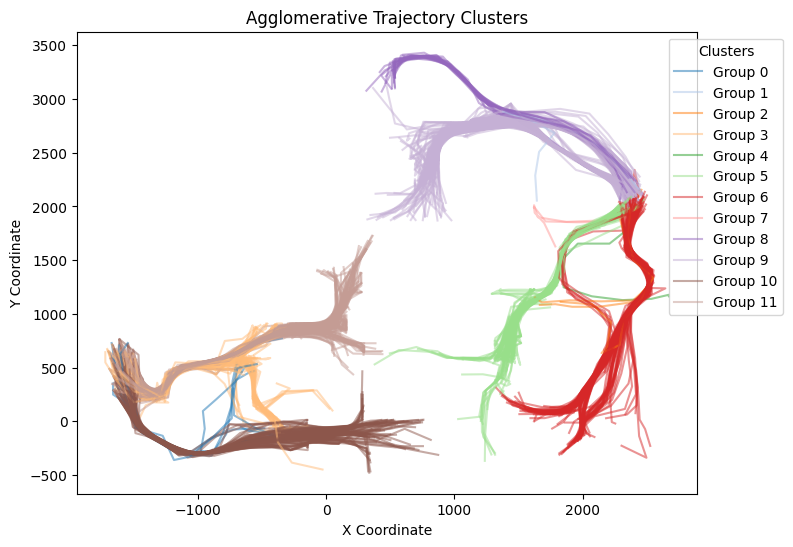

In [ ]:
# Collect Data for Clustering
trajectories_list: List[np.ndarray] = []
round_player_info: Dict[Tuple[int, str], List[Tuple[int, str]]] = {}
for match in all_matches_data:
    num_rounds = all_matches_data[match]['n']
    for player in all_matches_data[match]['t']:
        for round_num, trajectory in all_matches_data[match]['t'][player].items():
            trajectories_list.append(np.array(trajectory))
            key = (num_rounds, match)
            if key not in round_player_info:
                round_player_info[key] = []
            round_player_info[key].append((round_num, player))

# Perform Clustering for Individual Trajectories
(strategies_map, labels) = cluster(trajectories_list)
print(strategies_map)
plot_clusters(trajectories_list, labels)

In [ ]:
# Map Cluster Labels to Player Trajectories
all_trajectories_per_game_per_team = []
for match_id in round_player_info:
    mid = len(round_player_info[match_id]) // 2
    t1_data = round_player_info[match_id][:mid] # Team 1 Occupies the first half of the data
    t2_data = round_player_info[match_id][mid:] # Team 2 Occupies the second half of the data
    if t1_data[0][0] != 1 or t2_data[0][0] != 1:
        raise Exception("Data has not split correctly.")
    t1_round_trajectories = {}
    t2_round_trajectories = {}
    label_list = labels.tolist()
    for (round_number, _) in t1_data:
        if round_number not in t1_round_trajectories:
            t1_round_trajectories[round_number] = []
        t1_round_trajectories[round_number].append(label_list.pop(0))
    for (round_number, _) in t2_data:
        if round_number not in t2_round_trajectories:
            t2_round_trajectories[round_number] = []
        t2_round_trajectories[round_number].append(label_list.pop(0))
    all_trajectories_per_game_per_team.append(list(t1_round_trajectories.values()))
    all_trajectories_per_game_per_team.append(list(t2_round_trajectories.values()))
print("- - -Example Trajectories for a Team on a Singular Map- - -")
print("Array: [A, B, C, D, E] Represents Initial Trajectories of a Team in a Given Round")
print("Values: The Cluster Label for the input Trajectory (the Grouping)")
print(type(all_trajectories_per_game_per_team))
all_trajectories_per_game_per_team[0][:10]
        

IndexError: pop from empty list

In [ ]:
from sklearn.metrics import pairwise_distances
from helpers import jaccard_distance

flat_trajectories_sets = []
for arr in all_trajectories_per_game_per_team:
    flat_trajectories_sets += map(set, arr)

jaccards = pairwise_distances(
    flat_trajectories_sets, 
    metric = jaccard_distance
)

clustering = AgglomerativeClustering(
    n_clusters = 5,
    metric = 'precomputed', 
    linkage = 'average'
)
labels = clustering.fit_predict(jaccards)
labels[:10]

ImportError: cannot import name 'jaccard_distance' from 'helpers' (/Users/mattkingsbury/cs_msc/src/helpers.py)